# This notebook closely follows this tutorial: 
https://keras.io/examples/generative/dcgan_overriding_train_step
# The data set used can be found at:
https://www.kaggle.com/datasets/soumikrakshit/anime-faces
#### These images are placed in the ./images directory

In [7]:
import tensorflow as tf
import keras
import numpy as np
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, BatchNormalization, LeakyReLU, Reshape, Flatten, Dropout

### Some hyperparameters

In [2]:
BATCH_SIZE = 16
NOISE_DIM = 64

In [3]:
dataset = keras.preprocessing.image_dataset.image_dataset_from_directory(
    "images",
    label_mode = None,
    image_size = (64, 64),
    batch_size = BATCH_SIZE,
    shuffle = True
).map(lambda x: x/255.0)


Found 21551 files belonging to 1 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-24 15:57:50.590740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 15:57:50.590840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Let's define a method that lets us easily see what our dataset looks like

In [4]:
def visualize_dataset():
    for x in dataset:
        fig = plt.figure(figsize=(10,10))
        for i in range(16):
            fig.add_subplot(4, 4, i+1)
            image = keras.preprocessing.image.array_to_img(x[i] * 255.0)
            plt.imshow(image)
            plt.axis("off")
        break


2022-03-24 15:57:50.707226: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


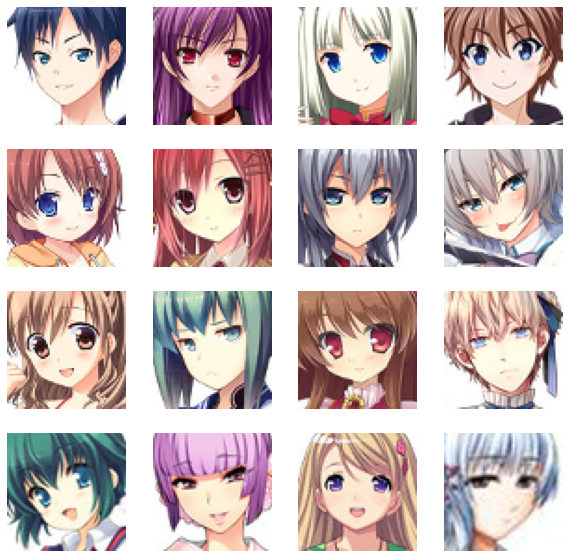

In [5]:
visualize_dataset()

#### I'll also make a utility function that will make it easy to look at the images generated by our model and a function to generate random noise

In [6]:
def visualize_tensors(tensor):
    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        fig.add_subplot(4, 4, i+1)
        image = keras.preprocessing.image.array_to_img(tensor[i] * 255.0)
        plt.imshow(image)
        plt.axis("off")

def get_noise(batch_size = BATCH_SIZE):
    return tf.random.normal((batch_size, NOISE_DIM))

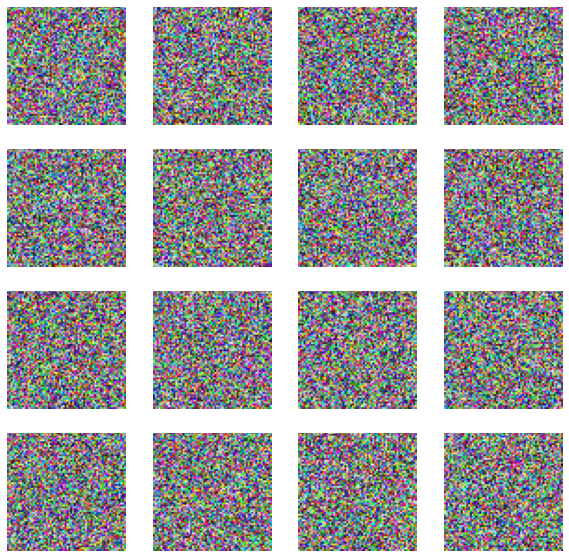

In [7]:
# can test the above function really quickly with
visualize_tensors(np.random.rand(16, 64, 64, 3))
# as we expect, it's random static :)

#### Create the Discriminator Model

In [8]:
class Discriminator(keras.Model):
    
    def __init__(self):
        super().__init__()
        self.discriminator = keras.Sequential([
            Input(shape=(64, 64, 3)),
            Conv2D(64, kernel_size = (4,4), strides=2, padding="same"),
            LeakyReLU(alpha=0.2),
            # BatchNormalization(),
            Conv2D(128, kernel_size=(4,4), strides=2, padding="same"),
            LeakyReLU(alpha=0.2),
            # BatchNormalization(),
            Conv2D(128, kernel_size=(4,4), strides=2, padding="same"),
            LeakyReLU(alpha=0.2),
            # BatchNormalization(),
            Flatten(),
            Dropout(0.2),
            Dense(1, activation="sigmoid")
        ])

    def call(self, x):
        return self.discriminator(x)        

In [9]:
disc = Discriminator()
print(disc.discriminator.summary())

#### Create the Generator Model

In [10]:
class Generator(keras.Model):
    
    def __init__(self):
        super().__init__()
        self.generator = keras.Sequential([
            Input(shape=(NOISE_DIM)),
            Dense(8 * 8 * 128),
            Reshape((8,8, 128)),
            Conv2DTranspose(128, kernel_size=(4,4), strides = 2, padding = "same"),
            LeakyReLU(alpha = 0.2),
            # BatchNormalization(),
            Conv2DTranspose(256, kernel_size=(4,4), strides = 2, padding = "same"),
            LeakyReLU(alpha = 0.2),
            # BatchNormalization(),
            Conv2DTranspose(512, kernel_size=(4,4), strides = 2, padding = "same"),
            LeakyReLU(alpha = 0.2),
            # BatchNormalization(),
            Conv2D(3, kernel_size = (5,5), padding="same", activation="sigmoid")
            
        ])

    def call(self, x):
        return self.generator(x) 

In [11]:
gen = Generator()
gen.generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              532480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)      

#### Now we can write a custom training step to train the two models

In [12]:
gen_opt = keras.optimizers.adam_v2.Adam(1e-4)
disc_opt = keras.optimizers.adam_v2.Adam(1e-4)

# disc_opt = keras.optimizers.Adam(1e-4)
loss = keras.losses.BinaryCrossentropy()

In [13]:
def train_step_ss(real_images, stepnum):
    size = real_images.shape[0]
    noise = get_noise(size)



    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

        d_real_preds = disc.discriminator(real_images)

        fake_images = gen.generator(noise)
        d_fake_preds = disc.discriminator(fake_images)

        d_loss = tf.reduce_mean(d_real_preds - d_fake_preds)

        g_loss = tf.reduce_mean(d_fake_preds)
        print(g_loss)


    d_grads = d_tape.gradient(d_loss, disc.discriminator.trainable_weights)
    disc_opt.apply_gradients(zip(d_grads, disc.discriminator.trainable_weights))

    g_grads = g_tape.gradient(g_loss, gen.generator.trainable_weights)
    gen_opt.apply_gradients(zip(g_grads, gen.generator.trainable_weights))


In [14]:
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_DIM))

    # Decode them to fake images
    generated_images = gen.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = disc.discriminator(combined_images)
        d_loss = loss(labels, predictions)
    grads = tape.gradient(d_loss, disc.discriminator.trainable_weights)
    disc_opt.apply_gradients(
        zip(grads, disc.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, NOISE_DIM))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        predictions = disc.discriminator(gen.generator(random_latent_vectors))
        g_loss = loss(misleading_labels, predictions)
    grads = tape.gradient(g_loss, gen.generator.trainable_weights)
    gen_opt.apply_gradients(zip(grads, gen.generator.trainable_weights))


In [15]:
rand_seed = get_noise()

In [ ]:
for epoch in range(6, 25):
    for index, x in tqdm.tqdm(dataset.enumerate()):
        train_step(x)
        if (index % 50 == 0):
            visualize_tensors(gen.generator(rand_seed))
            plt.savefig("./generated/epoch" + str(epoch)+ "itr" +str(int(index)) + ".jpg")
            plt.clf()

### I'm only going to train for 5 epochs, since each one takes about 30 minutes on my mac :(

## After Training, I'll make a gif of the images that we saved


In [17]:
import glob
import os

In [34]:
def directory_to_gif():
    images = os.listdir("./generated")
    images.sort()
    images = images[1:]
    images = [Image.open(f"./generated/{image}") for image in images]
    first = images[0]
    first.save("training.gif", format="GIF", append_images=images, save_all=True, duration=100, loop=0)

In [35]:
directory_to_gif()